# Burn In Test
A test file to demonstrate the issues with starting positions in multi-modal distributions

In [1]:
import jax
import jax.numpy as jnp
import numpyro
import numpy as np
from numpyro import infer, distributions
from chainconsumer import ChainConsumer
import matplotlib.pylab as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
numpyro.set_host_device_count(1)
jax.config.update('jax_platform_name', 'cpu')

/home/hughmc/anaconda3/envs/nestconda_dev/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
width = .25
relheight = 0
spacing = 3

xmin=-8
xmax=5
ymin=-8
ymax=5

def potential(x,y):
    
    out=0
    
    #low likelihood peaks
    out+=jnp.exp(-1/2* (jnp.power((x-spacing),2) + jnp.power(y,2)) / width**2)
    out+=jnp.exp(-1/2* (jnp.power((x+spacing),2) + jnp.power(y,2))/ width**2)
    out+=jnp.exp(-1/2* (jnp.power((x),2)   + jnp.power(y-spacing,2))/ width**2)
    out+=jnp.exp(-1/2* (jnp.power((x),2)   + jnp.power(y+spacing,2))/ width**2)
    
    #High likelihood peak in middle
    out+=jnp.exp(-1/2* (jnp.power((x),2)+jnp.power(y,2))/ width**2)*relheight
    
    return(out)


def model():
    x = numpyro.sample('x', numpyro.distributions.Uniform(xmin,xmax))
    y = numpyro.sample('y', numpyro.distributions.Uniform(ymin,ymax))
    
    numpyro.factor('potfunc',jnp.log(potential(x,y) + 1E-15))
    
startpos={'x':-4.9, 
          'y':-4.9}

nchains = 50
nsamples = 400
nburn=400
sampler = numpyro.infer.MCMC(
    numpyro.infer.NUTS(model, init_strategy = numpyro.infer.init_to_value()),
    num_warmup  = nburn,
    num_samples = nsamples,
    num_chains  = nchains,
    progress_bar= False,
    chain_method = 'sequential',
)
print("Starting Sampling...")
sampler.run(jax.random.PRNGKey(1))
print("Sampling Done")
output=sampler.get_samples()

Starting Sampling...
Sampling Done


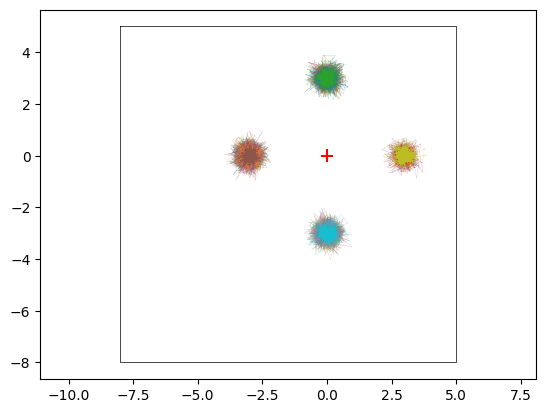

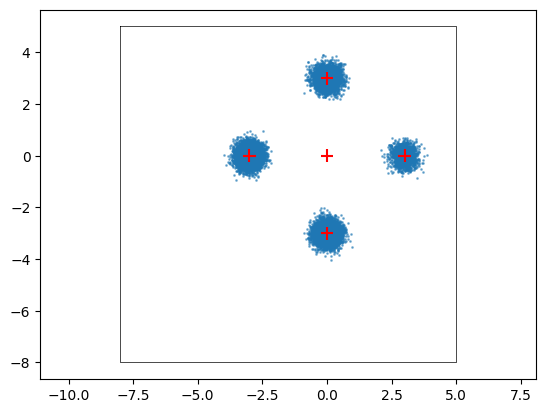

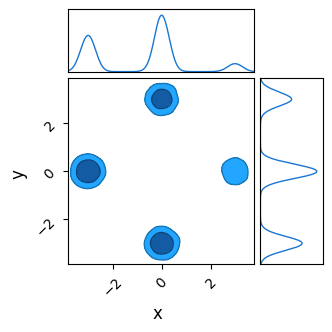

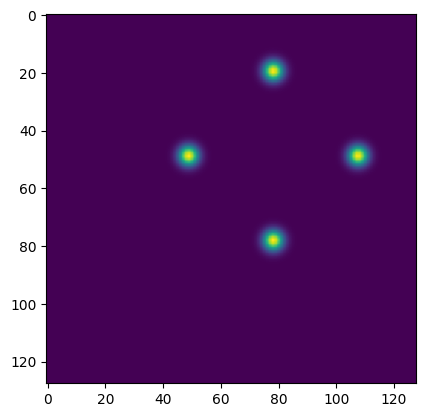

In [4]:
plt.figure()
plt.axis('equal')
plt.plot([xmin,xmax,xmax,xmin,xmin],[ymax,ymax,ymin,ymin,ymax],c='k',lw=0.5)
plt.errorbar([-spacing,0,0,0,spacing],[0,-spacing,0,spacing,0],xerr=width,yerr=width,c='r',fmt='none')
for i in range(nchains):
    plt.plot(output['x'][i*nsamples:(i+1)*nsamples],output['y'][i*nsamples:(i+1)*nsamples],lw=0.1)
plt.show()

plt.figure()
plt.axis('equal')
plt.scatter(output['x'],output['y'], s=1, alpha=0.5)
plt.plot([xmin,xmax,xmax,xmin,xmin],[ymax,ymax,ymin,ymin,ymax],c='k',lw=0.5)
plt.errorbar([-spacing,0,0,0,spacing],[0,-spacing,0,spacing,0],xerr=width,yerr=width,c='r',fmt='none')
plt.show()

c= ChainConsumer()
c.add_chain([output['x'],output['y']], parameters=['x','y'])
c.plotter.plot()
plt.show()

plt.figure()
X,Y = jnp.meshgrid(jnp.linspace(xmin,xmax, 128), jnp.linspace(ymin,ymax, 128))
Z = potential(X,Y)
plt.imshow(Z[::-1,:])
plt.show()


In [18]:
from numpyro.contrib.nested_sampling import NestedSampler

ns = NestedSampler(model, constructor_kwargs={"num_live_points":nchains*10, "max_samples":nchains*nsamples})
print("Doing Nested Sampling")
ns.run(jax.random.PRNGKey(0))
print("Done")

Doing Nested Sampling
Done


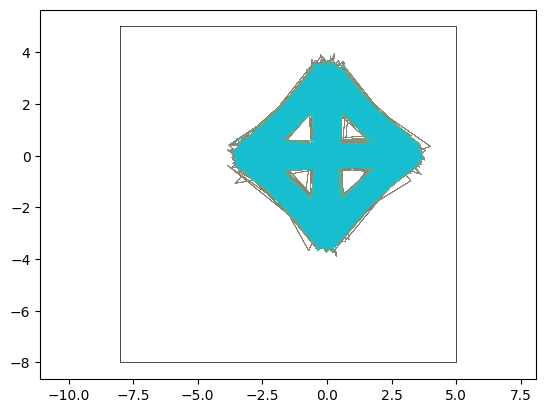

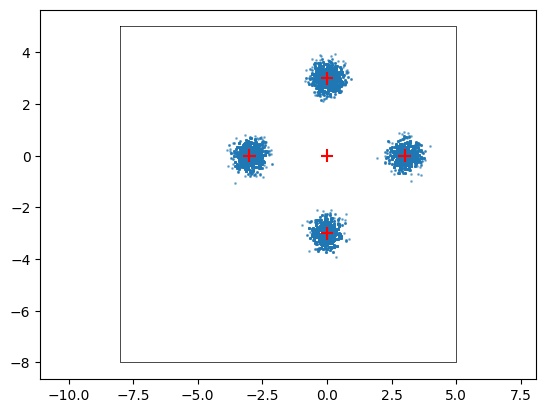

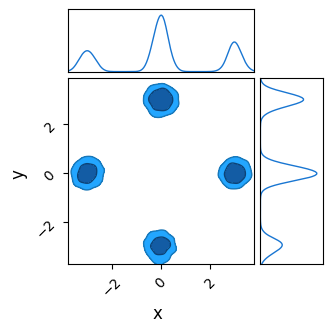

In [19]:
output_ns=ns.get_samples(jax.random.PRNGKey(0),nchains*nsamples)
plt.figure()
plt.axis('equal')
plt.plot([xmin,xmax,xmax,xmin,xmin],[ymax,ymax,ymin,ymin,ymax],c='k',lw=0.5)
plt.errorbar([-spacing,0,0,0,spacing],[0,-spacing,0,spacing,0],xerr=width,yerr=width,c='r',fmt='none')
for i in range(nchains):
    plt.plot(output_ns['x'],output_ns['y'],lw=0.1)
plt.show()

plt.figure()
plt.axis('equal')
plt.scatter(output_ns['x'],output_ns['y'], s=1, alpha=0.5)
plt.plot([xmin,xmax,xmax,xmin,xmin],[ymax,ymax,ymin,ymin,ymax],c='k',lw=0.5)
plt.errorbar([-spacing,0,0,0,spacing],[0,-spacing,0,spacing,0],xerr=width,yerr=width,c='r',fmt='none')
plt.show()

c= ChainConsumer()
c.add_chain([output_ns['x'],output_ns['y']], parameters=['x','y'])
c.plotter.plot()
plt.show()
